In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

In [6]:

from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

# Get the Hubble constant in the default units (km/s/Mpc)
H0 = cosmo.H0

# Convert 1/H0 to gigayears
H0_inverse = (1 / H0).to(u.Gyr)

print(f"1/H0 in gigayears: {H0_inverse:.3f}")

1/H0 in gigayears: 14.452 Gyr


In [7]:
print(f'H0: {H0:.10f}')

H0: 67.6600000000 km / (Mpc s)


# 1. Calculate the Age of the Universe

In [3]:
def integrand(a, omegam, omegalamb):
    omega0 = omegam + omegalamb
    y = (omegam/a+omegalamb*a**2+(1-omega0))**(-1/2)
    return y
def AgeofUniverse(ScaleFactor, omegam, omegalamb):
    I = quad_vec(integrand,0,ScaleFactor, args=(omegam, omegalamb))
    T = I[0]*H0_inverse # age is in Gyr, 1/H_0 ~ 14.452 Gyr
    return T


In [25]:
OmegamArr = np.arange(1,100)/100
OmegalambArr = np.arange(1,100)/100
FlatOmegalambArr = 1-OmegamArr
OmegamX, OmegalambY = np.meshgrid(OmegamArr, OmegalambArr)
#_, FlatOmegalambY = np.meshgrid(OmegamArr, FlatOmegalambArr)
AgeArr = AgeofUniverse(1, OmegamX, OmegalambY)
FlatAgeArr = AgeofUniverse(1, OmegamArr, FlatOmegalambArr)

# Ωm = 0.31에 가장 가까운 인덱스 찾기
idx_m = np.abs(OmegamArr - 0.31).argmin()
idx_l = np.abs(OmegalambArr - 0.69).argmin()
print(f"Ωm = 0.31, ΩΛ = 0.69일 때의 우주 나이: {AgeArr[idx_l,idx_m]:.3f} Gyr")

Ωm = 0.31, ΩΛ = 0.69일 때의 우주 나이: 13.805 Gyr Gyr


In [65]:
Omegamcur = cosmo.Om0
Omegalambcur = 1-Omegamcur
Agecur = AgeofUniverse(1, Omegamcur, Omegalambcur)

print(f"Omegamcur: {Omegamcur:.3f}")
print(f"Omegalambcur: {Omegalambcur:.3f}")
print(f"Age of Universe: {Agecur:.3f}")

Omegamcur: 0.310
Omegalambcur: 0.690
Age of Universe: 13.810 Gyr


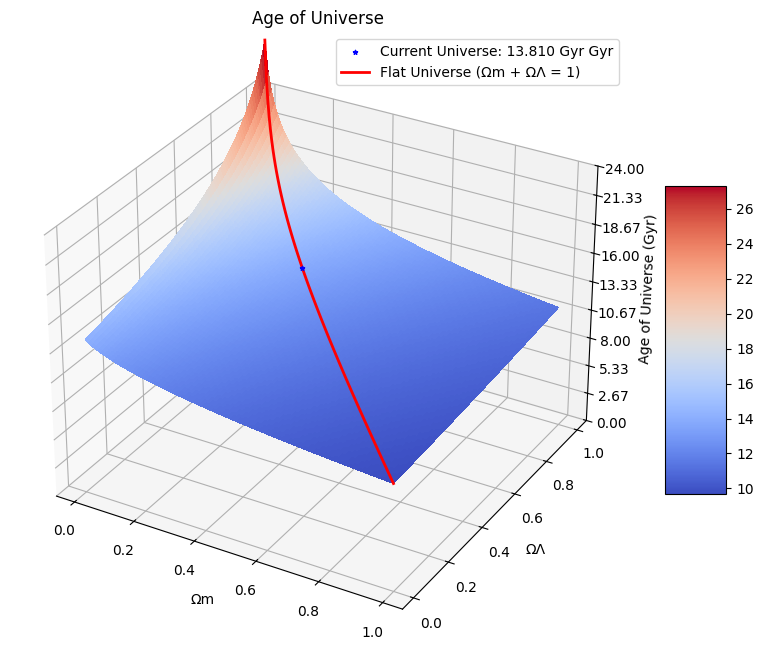

In [73]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d',computed_zorder=False)
ax.scatter(Omegamcur, Omegalambcur, Agecur, c='blue', s=10, marker='*', label=f'Current Universe: {Agecur:.3f} Gyr',zorder=3, depthshade=False)
surf = ax.plot_surface(OmegamX, OmegalambY, AgeArr, 
                      rstride=1, cstride=1, 
                      cmap=cm.coolwarm, 
                      linewidth=0, 
                      antialiased=False, alpha=1)  # alpha 값을 더 낮춰서 투명도 증가
ax.plot3D(OmegamArr, FlatOmegalambArr, FlatAgeArr, 'red', linewidth=2, label='Flat Universe (Ωm + ΩΛ = 1)', zorder=2)


ax.set_xlabel('Ωm')
ax.set_ylabel('ΩΛ')
ax.set_zlabel('Age of Universe (Gyr)')
ax.set_zlim(0, 24)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.legend()
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Age of Universe')
plt.show()

# 2. Calculate Luminosity Distance

In [11]:

from astropy.constants import c
c_proper = c.to('Mpc/Gyr')

In [186]:
def E_inverse(z, omegam, omegalamb): # calculate E(z)
    omega0 = omegam + omegalamb
    y = (omegam*(1+z)**3+omegalamb+(1-omega0)*(1+z)**2)**(1/2)
    return 1/y

def R_k(omegam, omegalamb): # calculate curvature scale
     omega0 = omegam + omegalamb
     R_k = 1/np.sqrt(abs(1-omega0))
     return R_k

def Properdist(z, omegam, omegalamb): # return S_k(r) in Mpc
    if type(omegam) == float:
        omegam = np.array([omegam])
    if type(omegalamb)==float:
        omegalamb = np.array([omegalamb])
    omega0 = omegam + omegalamb
    result = np.zeros_like(omega0)
    
    # 1-omega0 == 0인 경우
    mask_flat = (1-omega0 == 0)
    result[mask_flat] = H0_inverse * c_proper * quad_vec(E_inverse, 0, z, args=(omegam[mask_flat], omegalamb[mask_flat]))[0]
    
    # 1-omega0 < 0인 경우 (closed universe)
    mask_closed = (1-omega0 < 0)
    R_k_closed = R_k(omegam[mask_closed], omegalamb[mask_closed])
    result[mask_closed] = R_k_closed * c_proper * H0_inverse * np.sin(1/R_k_closed * quad_vec(E_inverse, 0, z, args=(omegam[mask_closed], omegalamb[mask_closed]))[0])
    
    # 1-omega0 > 0인 경우 (open universe)
    mask_open = (1-omega0 > 0)
    R_k_open = R_k(omegam[mask_open], omegalamb[mask_open])
    result[mask_open] = R_k_open * c_proper * H0_inverse * np.sinh(1/R_k_open * quad_vec(E_inverse, 0, z, args=(omegam[mask_open], omegalamb[mask_open]))[0])
    
    return result

def Lumdist(z, properdist):
    z = np.array(z)
    if z.ndim == 0:
        z = np.array([z])
    return properdist * (1+z)

def Angdist(z, properdist):
    z = np.array(z)
    if z.ndim == 0:
        z = np.array([z])
    return properdist / (1+z)



     

In [183]:
omega = 1.
type(omega)==float

True

In [187]:

Omegamcur = cosmo.Om0
Omegalambcur = 1-Omegamcur
d = Properdist(1,np.array([Omegamcur]),np.array([Omegalambcur]))
Ld = Lumdist(1,d)
print(f'Luminosity Distance: {Ld[0]:.3f} Mpc')

Luminosity Distance: 6797.436 Mpc


In [191]:
OmegamArr = np.arange(1,100,2)/100
OmegalambArr = np.arange(1,100,2)/100



FlatOmegalambArr = 1-OmegamArr
OmegamX, OmegalambY = np.meshgrid(OmegamArr, OmegalambArr)

In [192]:
comovingdistarr = Properdist(1,OmegamX,OmegalambY)
lumdistarr = Lumdist(1,comovingdistarr)


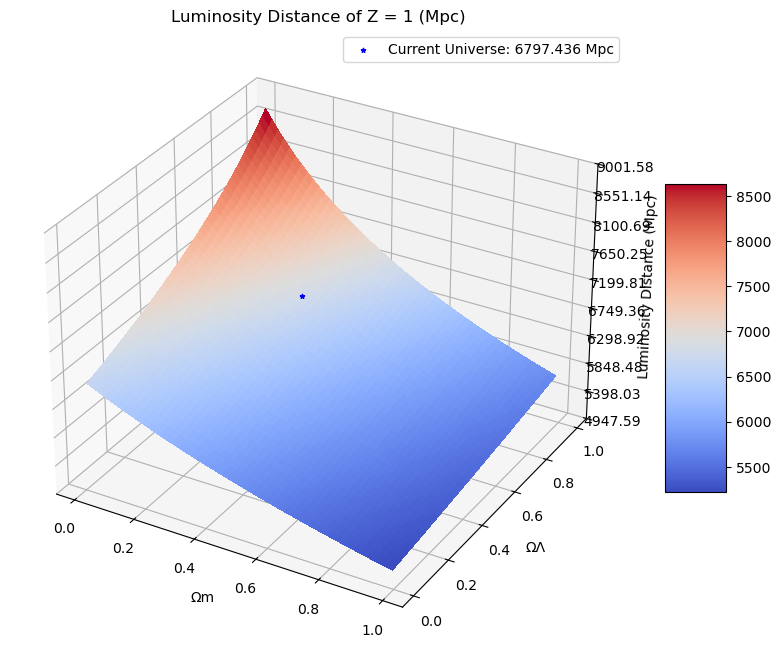

In [193]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d',computed_zorder=False)
ax.scatter(Omegamcur, Omegalambcur, Ld, c='blue', s=10, marker='*', label=f'Current Universe: {Ld[0]:.3f} Mpc',zorder=3, depthshade=False)
surf = ax.plot_surface(OmegamX, OmegalambY, lumdistarr, 
                      rstride=1, cstride=1, 
                      cmap=cm.coolwarm, 
                      linewidth=0, 
                      antialiased=False, alpha=1)  # alpha 값을 더 낮춰서 투명도 증가
#ax.plot3D(OmegamArr, FlatOmegalambArr, FlatAgeArr, 'red', linewidth=2, label='Flat Universe (Ωm + ΩΛ = 1)', zorder=2)


ax.set_xlabel('Ωm')
ax.set_ylabel('ΩΛ')
ax.set_zlabel('Luminosity Distance (Mpc)')
#ax.set_zlim(0, 24)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#ax.set_zticks(np.arange(400,800,100))
plt.legend()
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Luminosity Distance of Z = 1 (Mpc)')
plt.show()

### Drawing lines

In [205]:
zarr = np.linspace(0,100,101)/10
omegam = np.array([0.31,1,0])
omegalamb = 1-omegam
dist = np.zeros((len(zarr),) + omegam.shape)
for i,zval in enumerate(zarr):
    propdist = Properdist(zval, omegam, omegalamb)
    dist[i] = Lumdist(zval, propdist)

In [199]:
dist = dist.T
dist = dist/c_proper/H0_inverse

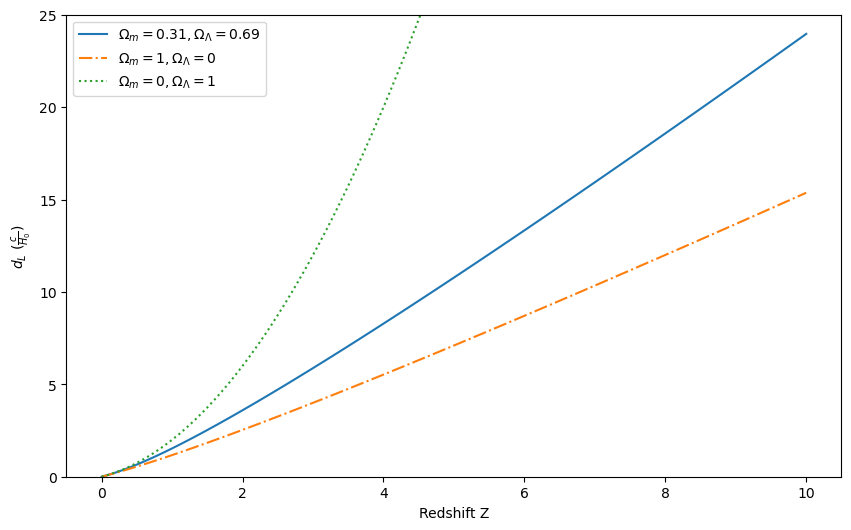

In [200]:
plt.figure(figsize=(10,6))
plt.plot(zarr, dist[0], '-' ,label = r'$\Omega_m = 0.31, \Omega_\Lambda = 0.69$')
plt.plot(zarr, dist[1], '-.' ,label = r'$\Omega_m = 1, \Omega_\Lambda = 0$')
plt.plot(zarr, dist[2], ':' ,label = r'$\Omega_m = 0, \Omega_\Lambda = 1$')
plt.ylim([0,25])
plt.ylabel(r'$d_L$ $(\frac{c}{H_0})$')
plt.xlabel('Redshift Z')
plt.legend()

### Animation

In [197]:
zrange = np.arange(0.1,10.0,0.1)
Benchmark = np.zeros((len(zrange),))
for i, zval in enumerate(zrange):
    propdist_Bench = Properdist(zval, 0.31, 0.69)
    Benchmark[i] = Lumdist(zval, propdist_Bench)[0]

In [213]:
OmegamArr = np.arange(1,500,2)/100
OmegalambArr = np.arange(1,500,2)/100
OmegamX, OmegalambY = np.meshgrid(OmegamArr, OmegalambArr)
distarr =np.zeros((len(zrange),) + OmegamX.shape)
for i,zval in enumerate(zrange):
    propdist = Properdist(zval, OmegamX, OmegalambY)
    distarr[i] = Lumdist(zval, propdist)/Benchmark[i]



/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_2644/4134921430.py:3: RuntimeWarning: invalid value encountered in sqrt
  y = (omegam*(1+z)**3+omegalamb+(1-omega0)*(1+z)**2)**(1/2)
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_2644/4134921430.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/y


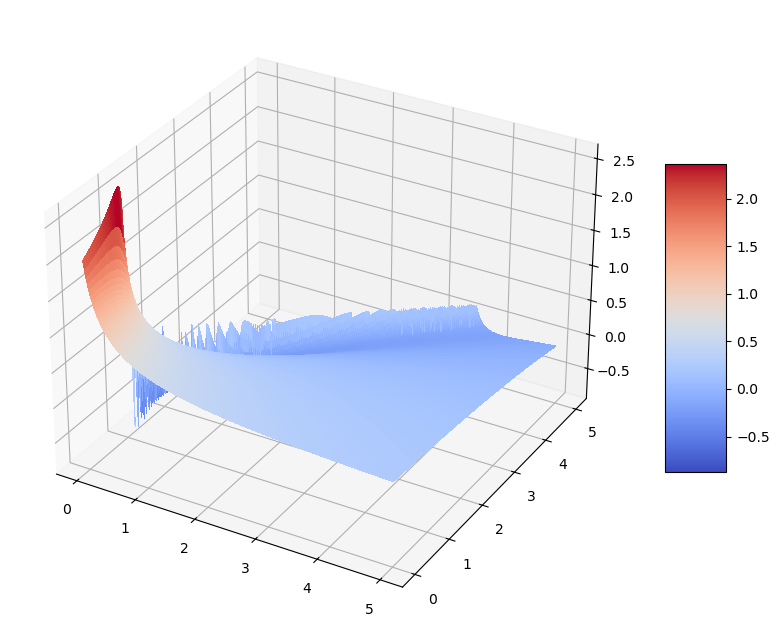

In [224]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(OmegamX, OmegalambY, distarr[74], 
                        rstride=1, cstride=1, 
                        cmap='coolwarm',
                        linewidth=0, 
                        antialiased=False)
plt.colorbar(surf, shrink=0.5, aspect=5)

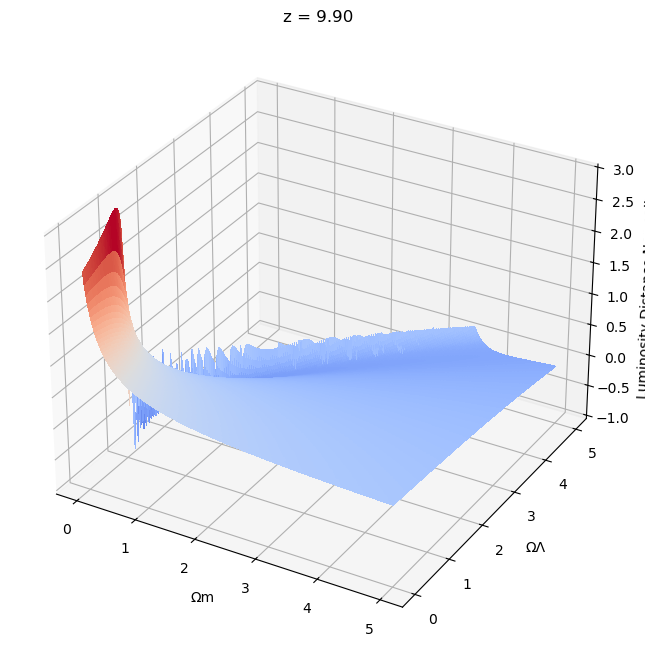

In [229]:
# 애니메이션 설정

from matplotlib.animation import FuncAnimation

# 애니메이션 설정
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
vmin = np.min(distarr)
vmax = np.max(distarr)
# 애니메이션 함수
def update(frame):
    ax.clear()
    surf = ax.plot_surface(OmegamX, OmegalambY, distarr[frame], 
                          rstride=1, cstride=1, 
                          cmap='coolwarm',
                          linewidth=0, 
                          antialiased=False)
    ax.set_xlabel('Ωm')
    ax.set_ylabel('ΩΛ')
    
    ax.set_zlabel('Luminosity Distance Normalized')
    ax.set_title(f'z = {zrange[frame]:.2f}')
    return surf,

# 애니메이션 생성
anim = FuncAnimation(fig, update, frames=len(zrange), 
                    interval=100,  # 100ms 간격으로 프레임 변경
                    blit=False)  # blit=False로 변경

anim.save('/Users/john1256/KASI_Ms/2025/luminosity_distance.gif', writer='pillow')
plt.show()

# 3. Calculate Angular Diameter distace

In [153]:
Omegamcur = cosmo.Om0
Omegalambcur = 1-Omegamcur
d = Properdist(1,np.array([Omegamcur]),np.array([Omegalambcur]))
Ad = Angdist(1,d)
print(f'Angular-diameter Distance: {Ad[0]:.3f} Mpc')

Angular-diameter Distance: 1699.359 Mpc


In [154]:
comovingdistarr = Properdist(1,OmegamX,OmegalambY)
angdistarr = Angdist(1,comovingdistarr)

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_2644/2235759448.py:3: RuntimeWarning: invalid value encountered in sqrt
  y = (omegam*(1+z)**3+omegalamb+(1-omega0)*(1+z)**2)**(1/2)


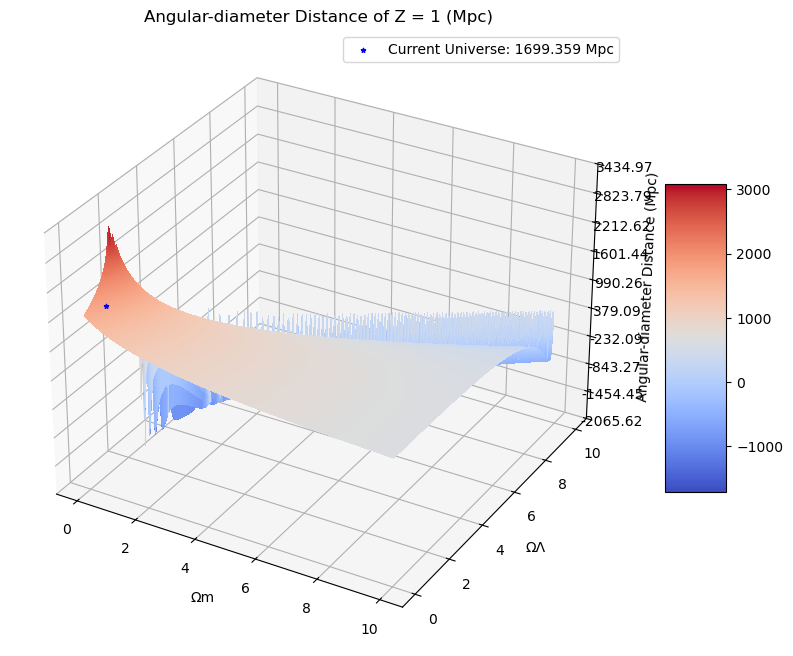

In [155]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d',computed_zorder=False)
ax.scatter(Omegamcur, Omegalambcur, Ad, c='blue', s=10, marker='*', label=f'Current Universe: {Ad[0]:.3f} Mpc',zorder=3, depthshade=False)
surf = ax.plot_surface(OmegamX, OmegalambY, angdistarr, 
                      rstride=1, cstride=1, 
                      cmap=cm.coolwarm, 
                      linewidth=0, 
                      antialiased=False, alpha=1)  # alpha 값을 더 낮춰서 투명도 증가
#ax.plot3D(OmegamArr, FlatOmegalambArr, FlatAgeArr, 'red', linewidth=2, label='Flat Universe (Ωm + ΩΛ = 1)', zorder=2)


ax.set_xlabel('Ωm')
ax.set_ylabel('ΩΛ')
ax.set_zlabel('Angular-diameter Distance (Mpc)')
#ax.set_zlim(0, 24)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#ax.set_zticks(np.arange(400,800,100))
plt.legend()
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Angular-diameter Distance of Z = 1 (Mpc)')
plt.show()

### Animation